<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/image_segmentation_training_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation**
Image segmentation is a critical task in computer vision that involves partitioning an image into distinct regions or segments, each corresponding to specific objects or parts within the scene. This process enables more detailed analysis and understanding of visual data, making it essential for applications such as medical imaging, autonomous driving, and scene understanding. By assigning a label to every pixel in an image, segmentation facilitates tasks like object detection, recognition, and tracking, allowing for improved accuracy and performance in downstream applications.

A variety of models have been developed to tackle image segmentation, including classical approaches like Thresholding and Region-Based Segmentation, as well as modern deep learning architectures such as Fully Convolutional Networks (FCNs), Mask R-CNN, and the U-Net model.

#**U-Net Architecture**

Originally developed for biomedical image segmentation but effective in other domains as, U-Net is characterized by its distinctive U-shaped structure, which comprises a contracting path for feature extraction and an expansive path for precise localization. This architecture enables the model to capture both high-level context and fine-grained details, making it highly effective in applications where accurate pixel-level predictions are essential.At its core, U-Net employs a series of convolutional layers and skip connections that facilitate the flow of information between the encoder and decoder paths. This design not only enhances the model's ability to recover spatial information but also mitigates the loss of critical features that can occur during downsampling

The two aspects that we need to keep in mind while performing segmentation are as follows:
* The shape and structure of the objects in the original image remain the same in the segmented output.
* Leveraging a fully convolutional architecture (and not a structure where we flatten a certain layer) can help here, since we are using one image as input and another as output.

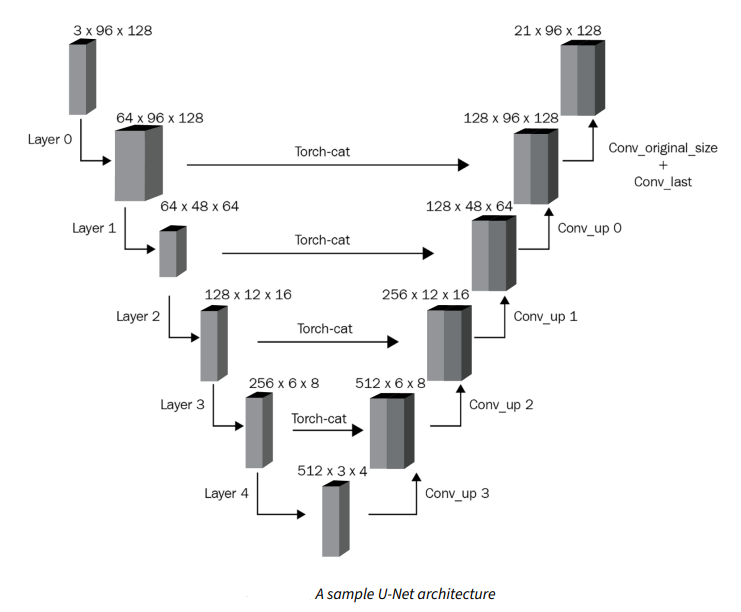

# **Implementing semantic segmentation using U-Net**

In [ ]:
# Setup Environment
!pip install -q --upgrade torch_snippets

#from torch_snippets import *
import torch
import torch.optim as optim
from torch_snippets.paths import stems
from torch_snippets.loader import read, randint
from torch_snippets.torch_loader import Report
from torch.utils.data import Dataset, DataLoader
import torch, glob, os, sys, pandas as pd, numpy as np , cv2, re
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16_bn
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset Downloader
class DataDownloader:
    def __init__(self, url):
        self.url = url
        self.data_dir = '../dataset1'
    def download_and_extract(self):
        if not os.path.exists(self.data_dir):
            self._download_file()
            self._extract_file()
            self._cleanup()
            self._clone_repository_prompt()
            print("Download and extraction completed.")
        else:
            print("Data already downloaded and exists.")
    def _download_file(self):
        os.system(f'wget --quiet {self.url}')
    def _extract_file(self):
        downloaded_files = glob.glob('*')  # Matche any file
        for file in downloaded_files:
            if file.endswith(('.tar.xz', '.zip', '.tar', '.gz', '.bz2')):
                os.system(f'tar -xf {file}') if file.endswith(('.tar.xz', '.tar')) else os.system(f'unzip {file}')
    def _cleanup(self):
        downloaded_files = glob.glob('*')
        for file in downloaded_files:
            if file.endswith(('.tar.xz', '.zip', '.tar', '.gz', '.bz2')):
                os.remove(file)
                print(f"Removed: {file}")
    def _clone_repository_prompt(self):
        clone_repo = input("\nWould you like to clone a repository? (yes/no): ").strip().lower()
        if clone_repo == 'yes':
            repo_url = input("Enter the repository URL: ").strip()
            self._clone_repository(repo_url)
        elif clone_repo == 'no':
            print("Skipping repository cloning.")
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")
    def _clone_repository(self, repo_url):
        os.system(f'git clone {repo_url}')
        repo_name = self._get_repo_name(repo_url)
        if repo_name:
            os.chdir(repo_name)
            print(f"Changed directory to: {repo_name}")

    def _get_repo_name(self, repo_url):
       match = re.search(r'([^/]+)(\.git)?$', repo_url)
        if match:
            return match.group(1)
        return None

# Dataset to fetch input and output for training
class ImageDataset(Dataset,DataDownloader):

    def __init__(self,split,downloader: DataDownloader):
        self.downloader = downloader
        self.data_dir = downloader.data_dir
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        # Check if items is empty
        if len(self.items) == 0:
            raise ValueError("No images found in the specified directory.")
        print(f"Data Directory: {self.data_dir}")
        print(f"Items Found: {len(self.items)}")
        self.tmfss = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]) # Imagenet
    def __len__(self): return len(self.items)
    def __getitem__(self,idx):
        image_path = f'dataset1/images_prepped_{self.split}/{self.items[idx]}.png'
        mask_path = f'dataset1/annotations_prepped_{self.split}/{self.items[idx]}.png'
        image = read(image_path,1)
        image = cv2.resize(image,(224,224))
        mask = read(mask_path)[:,:,0]
        mask = cv2.resize(mask, (224,224))
        # Convert mask to single channel (class indices)
        if mask.ndim == 3 and mask.shape[-1] == 3:
            # Mask is RGB, converted to class indices
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # convert to type long for CrossEntropyLoss
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask
    def choose(self): return self[randint(len(self))] # Select a random image index
    def collate_fn(self, batch):
        img, masks = list(zip(*batch))
        img = torch.cat([self.tmfss(im.copy()/255.)[None] for im in img]).float().to(device)
        ce_mask = torch.stack([mask for mask in masks]).long().to(device)  # Stack masks into a single tensor
        return img, ce_mask

# DataLoader
class DatasetLoader:
    def __init__(self, downloader, batch_size_train=4, batch_size_val=1):
        self.downloader = downloader
        self.batch_size_train = batch_size_train
        self.batch_size_val = batch_size_val
        # Initialize datasets
        self.train_dataset = ImageDataset('train', self.downloader)
        self.val_dataset = ImageDataset('test', self.downloader)
        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size_train,
            shuffle=True,
            collate_fn=self.train_dataset.collate_fn)
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size_val,
            shuffle=True,
            collate_fn=self.val_dataset.collate_fn)
    def get_train_loader(self):
        return self.train_loader
    def get_val_loader(self):
        return self.val_loader

# UNetModel Architecture
class UNetModel(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super(UNetModel, self).__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        # DownSample input image progressively
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        # Bridge between the encoder and decoder, captur high-level features
        # Convolutional Opertation, Increase depth of feature after bottleneck
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = self.conv(512, 1024)
        # UpSampling and feature concatenation from encoder
        self.up_conv6 = self.up_conv(1024, 512)
        self.conv6 = self.conv(512 + 512, 512)
        self.up_conv7 = self.up_conv(512, 256)
        self.conv7 = self.conv(256 + 512, 256) # 512 channels from the skip connection
        self.up_conv8 = self.up_conv(256, 128)
        self.conv8 = self.conv(128 + 256, 128)
        self.up_conv9 = self.up_conv(128, 64)
        self.conv9 = self.conv(64 + 128, 64)
        self.up_conv10 = self.up_conv(64, 32)
        self.conv10 = self.conv(32 + 64, 32)
        # Finial Layer
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Sequential Encoding
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        # Bottleneck Processing
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        #Decoding (upsamples and concatenating encoder features)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)
        return x

    @staticmethod
    def up_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True))

    @staticmethod
    def conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def UnetLoss(self, preds, targets):
        ce = nn.CrossEntropyLoss()
        ce_loss = ce(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

# Model Trainer
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, n_epochs):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.n_epochs = n_epochs

    def train_batch(self, data):
        self.model.train()
        ims, ce_masks = data
        _masks = self.model(ims)
        self.optimizer.zero_grad()
        # Debugging: Print shapes
        print(f"\nTrain - Predictions shape: {_masks.shape}, Targets shape: {ce_masks.shape}")
        loss, acc = self.criterion(_masks, ce_masks)
        loss.backward()
        self.optimizer.step()
        return loss.item(), acc.item()

    @torch.no_grad()
    def validate_batch(self, data):
        self.model.eval()
        ims, masks = data
        _masks = self.model(ims)
        print(f"\nValidate - Predictions shape: {_masks.shape}, Targets shape: {masks.shape}")
        loss, acc = self.criterion(_masks, masks)
        return loss.item(), acc.item()

    def run(self):
        log = Report(self.n_epochs)
        for epoch in range(self.n_epochs):
            # Training
            N = len(self.train_loader)
            for bx, data in enumerate(self.train_loader):
                loss, acc = self.train_batch(data)
                log.record(epoch + (bx + 1) / N, trn_loss=loss, trn_acc=acc, end='\r')

            # Validation
            N = len(self.val_loader)
            for bx, data in enumerate(self.val_loader):
                loss, acc = self.validate_batch(data)
                log.record(epoch + (bx + 1) / N, val_loss=loss, val_acc=acc, end='\r')

            log.report_avgs(epoch + 1)
        log.plot_epochs(['trn_loss','val_loss'])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.5 MB/s eta 0:00:00


Enter this URL: https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip 

Please enter the download URL: https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
Removed: dataset1.zip

Would you like to clone a repository? (yes/no): no
Skipping repository cloning.
Download and extraction completed.
Data Directory: ../dataset1
Items Found: 367
Data Directory: ../dataset1
Items Found: 101


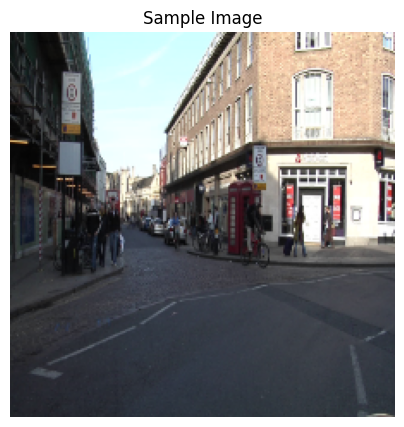

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:09<00:00, 61.3MB/s]


Streaming output truncated to the last 5000 lines.
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets shape: torch.Size([4, 224, 224])
EPOCH: 7.174  trn_loss: 0.340  trn_acc: 0.907  (134.92s - 241.22s remaining)
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets shape: torch.Size([4, 224, 224])
EPOCH: 7.185  trn_loss: 0.367  trn_acc: 0.895  (135.09s - 240.95s remaining)
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets shape: torch.Size([4, 224, 224])
EPOCH: 7.196  trn_loss: 0.234  trn_acc: 0.943  (135.26s - 240.69s remaining)
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets shape: torch.Size([4, 224, 224])
EPOCH: 7.207  trn_loss: 0.382  trn_acc: 0.887  (135.44s - 240.43s remaining)
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets shape: torch.Size([4, 224, 224])
EPOCH: 7.217  trn_loss: 0.251  trn_acc: 0.935  (135.61s - 240.17s remaining)
Train - Predictions shape: torch.Size([4, 12, 224, 224]), Targets sha

100%|██████████| 121/121 [00:00<00:00, 729.33it/s]


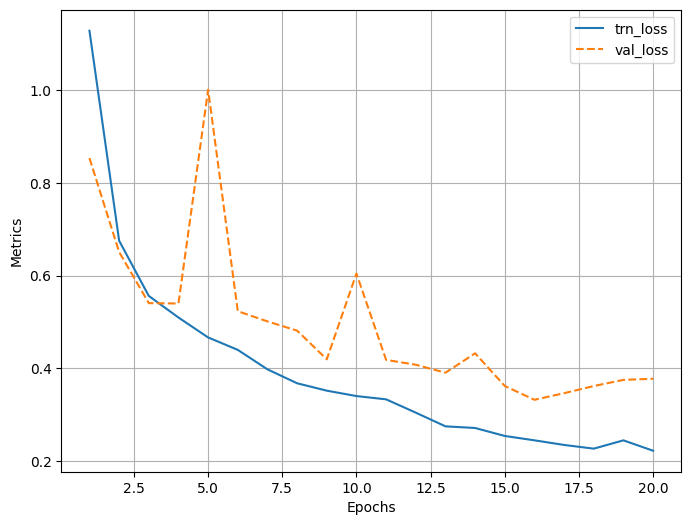

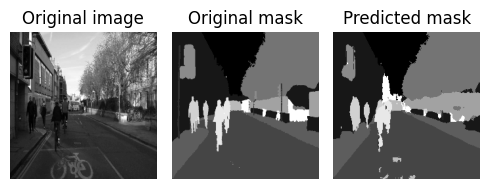

In [ ]:
from torch_snippets.loader import show

if __name__ == "__main__":

# Download Data
    print('Enter this URL: https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip','\n')
    url = input("Please enter the download URL: ")
    downloader = DataDownloader(url)
    downloader.download_and_extract()

# Dataset Loader
    dataset_loader = DatasetLoader(downloader)

# Access train and validation loaders
    train_loader = dataset_loader.get_train_loader()
    val_loader = dataset_loader.get_val_loader()
    show(dataset_loader.train_dataset[10][0], title='Sample Image') # Sample Image

# Initialize model
    model = UNetModel(pretrained=True, out_channels=12).to(device)

# Initialize loss function
    criterion = model.UnetLoss  # Using the compute_loss method from the UNetModel

# Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trainer instance
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, n_epochs=20)

# Start training
    trainer.run()
    from torch_snippets.loader import subplots

# Make Prediction
    im, mask = next(iter(val_loader))
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)
    subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
    ,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
    nc=3, titles=['Original image','Original mask','Predicted mask'])
